# SIIM-ISIC Melanoma Classification SoSe24

Der Folgende Block lädt relevante Libraries, die für dieses Porjekt benötigt werden

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras import models, layers, optimizers # type: ignore

warnings.filterwarnings('ignore')

datetime.datetime.now().strftime("Fertiggestellt um %X den %x")

2024-06-11 11:02:25.695193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 11:02:25.695308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 11:02:25.955631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'Fertiggestellt um 11:02:41 den 06/11/24'

# Laden der Bilder und dazugehörigen CSV Dateien. 
Der folgende Block lädt Bilder und CSV Daten. Diese werden multithreaded, um die Ladezeiten um etwa die x-Fache Prozessorkernanzahl zu verkrüzen

In [2]:

path_data_train = '/kaggle/input/siim-isic-melanoma-classification/train.csv'
path_image_train = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'

# Funktion zum Laden von Bildern
def load_image(image_path, target_size=(128, 128)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    return np.array(image)

def load_data(csv_file, image_dir, max_images=None, target_size=(128, 128), num_workers=None):
    data = pd.read_csv(csv_file)
    if max_images is not None:
        data = data.head(max_images)

    # Extrahieren der Bildnamen
    image_names = data['image_name'].values
    targets = data['target'].values  # Nur die Target Labels

    images = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for image_name in image_names:
            image_path = os.path.join(image_dir, image_name + '.jpg')
            futures.append(executor.submit(load_image, image_path, target_size))

        for future in tqdm(futures, desc="Lade Bilder", total=len(futures)):
            images.append(future.result())

    return np.array(images), np.array(targets), image_names

# Anzahl der Prozesse oder Threads einstellen
num_workers = os.cpu_count() or 1   # Alle verfügbaren Kerne, die das System erkennt, ansonsten 1

# Laden der Trainingsdaten mit den "target"-Labels
train_images, train_targets, train_image_names = load_data(path_data_train, path_image_train, max_images=None, num_workers=num_workers)

# Aufteilen der Trainingsdaten in Trainings- und Validierungssätze
train_images, val_images, train_targets, val_targets, train_image_names, val_image_names = train_test_split(
    train_images, train_targets, train_image_names, test_size=0.2, random_state=42, stratify=train_targets
)

# Verteilung der Labels überprüfen
print("Verteilung der Trainingslabels:", np.bincount(train_targets))
print("Verteilung der Validierungslabels:", np.bincount(val_targets))

datetime.datetime.now().strftime("Fertiggestellt um %X den %x")

Lade Bilder: 100%|██████████| 33126/33126 [44:15<00:00, 12.48it/s]


Verteilung der Trainingslabels: [26033   467]
Verteilung der Validierungslabels: [6509  117]


'Fertiggestellt um 11:47:01 den 06/11/24'

# Datenaugmentierung von Trainings- und Validierungsdaten
Der Folgende Block augmentiert die Validierungs- und Trainingsverteilung von "98 zu 2" zu "50 zu 50". Dies soll verhindern, dass das Modell nur Nullen bzw. "benign" ausgibt, wenn diese stark repräsentiert werden.


In [3]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_class_images(class_images, class_targets, augment_size, generator):
    augmented_images = []
    augmented_targets = []
    for i in tqdm(range(augment_size), desc="Augmentiere Bilder"):
        augmented_image = generator.random_transform(class_images[i % len(class_images)])
        augmented_images.append(augmented_image)
        augmented_targets.append(1)
    return np.array(augmented_images), np.array(augmented_targets)

# Extrahieren der unterrepräsentierten Klasse (label == 1) für Trainings- und Validierungsdaten
train_minority_class_images = train_images[train_targets == 1]
train_minority_class_targets = train_targets[train_targets == 1]
val_minority_class_images = val_images[val_targets == 1]
val_minority_class_targets = val_targets[val_targets == 1]

# Anzahl der benötigten augmentierten Bilder berechnen
train_augment_size = len(train_images[train_targets == 0]) - len(train_minority_class_targets)
val_augment_size = len(val_images[val_targets == 0]) - len(val_minority_class_targets)

# Augmentierung für Trainingsdaten
train_augmented_images, train_augmented_targets = augment_class_images(train_minority_class_images, train_minority_class_targets, train_augment_size, datagen)

# Augmentierung für Validierungsdaten
val_augmented_images, val_augmented_targets = augment_class_images(val_minority_class_images, val_minority_class_targets, val_augment_size, datagen)

# Kombinieren der augmentierten Bilder mit den ursprünglichen Daten
train_images_balanced = np.concatenate((train_images, train_augmented_images), axis=0)
train_targets_balanced = np.concatenate((train_targets, train_augmented_targets), axis=0)
val_images_balanced = np.concatenate((val_images, val_augmented_images), axis=0)
val_targets_balanced = np.concatenate((val_targets, val_augmented_targets), axis=0)

# Shufflen der Daten
def shuffle_data(images, targets):
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    return images[indices], targets[indices]

train_images_balanced, train_targets_balanced = shuffle_data(train_images_balanced, train_targets_balanced)
val_images_balanced, val_targets_balanced = shuffle_data(val_images_balanced, val_targets_balanced)

# Verteilung der Labels nach der Augmentation überprüfen
print("Verteilung der Trainingslabels nach der Augmentation:", np.bincount(train_targets_balanced))
print("Verteilung der Validierungslabels nach der Augmentation:", np.bincount(val_targets_balanced))

Augmentiere Bilder: 100%|██████████| 6392/6392 [00:20<00:00, 307.20it/s]


Verteilung der Trainingslabels nach der Augmentation: [26033 26033]
Verteilung der Validierungslabels nach der Augmentation: [6509 6509]


# Erstellen eines CNN Models

In [4]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

# Kompilieren und trainieren des Models

In [5]:

# Kompilieren des Modells mit einem angepassten Optimierer
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Anpassen des Modells an die Trainingsdaten
history = model.fit(
    train_images_balanced, train_targets_balanced, batch_size=32, epochs=5,
    validation_data=(val_images_balanced, val_targets_balanced)
)

# Vorhersagen auf den Validierungsdaten
val_predictions = (model.predict(val_images_balanced) > 0.5).astype("int32")

# Berechnung der Genauigkeit
accuracy = accuracy_score(val_targets_balanced, val_predictions)
print(f"Genauigkeit: {accuracy:.2f}")



Epoch 1/5
   6/1628 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.4825 - loss: 39.2595

I0000 00:00:1718106565.814887      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718106565.839794      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7605 - loss: 1.8972

W0000 00:00:1718106595.861111      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718106597.907631      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1628/1628 ━━━━━━━━━━━━━━━━━━━━ 46s 21ms/step - accuracy: 0.7605 - loss: 1.8964 - val_accuracy: 0.8978 - val_loss: 0.2582
Epoch 2/5
   7/1628 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.9315 - loss: 0.2201

W0000 00:00:1718106600.830803      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1628/1628 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.8967 - loss: 0.2509 - val_accuracy: 0.9257 - val_loss: 0.1970
Epoch 3/5
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9357 - loss: 0.1682 - val_accuracy: 0.9495 - val_loss: 0.1445
Epoch 4/5
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.9577 - loss: 0.1217 - val_accuracy: 0.9555 - val_loss: 0.1297
Epoch 5/5
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.9656 - loss: 0.1007 - val_accuracy: 0.8943 - val_loss: 0.2657
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Genauigkeit: 0.89


In [6]:
# Verteilung der Trainingslabels anzeigen
train_targets_unique, train_targets_counts = np.unique(train_targets, return_counts=True)
print("Verteilung der Trainingslabels:")
for value, count in zip(train_targets_unique, train_targets_counts):
    print(f"Label: {value}, Count: {count}")

# Verteilung der Validierungslabels anzeigen
val_targets_unique, val_targets_counts = np.unique(val_targets, return_counts=True)
print("Verteilung der Validierungslabels:")
for value, count in zip(val_targets_unique, val_targets_counts):
    print(f"Label: {value}, Count: {count}")

# Alternativ mit Pandas für detaillierte Statistik
train_targets_series = pd.Series(train_targets)
val_targets_series = pd.Series(val_targets)

print("\nDetaillierte Statistik der Trainingslabels:")
print(train_targets_series.value_counts())

print("\nDetaillierte Statistik der Validierungslabels:")
print(val_targets_series.value_counts())

# Beispielhafte Anzeige von ein paar Labels
print("\nEin paar Beispiel-Labels aus den Trainingsdaten:")
print(train_targets[:10])

print("\nEin paar Beispiel-Labels aus den Validierungsdaten:")
print(val_targets[:10])

Verteilung der Trainingslabels:
Label: 0, Count: 26033
Label: 1, Count: 467
Verteilung der Validierungslabels:
Label: 0, Count: 6509
Label: 1, Count: 117

Detaillierte Statistik der Trainingslabels:
0    26033
1      467
Name: count, dtype: int64

Detaillierte Statistik der Validierungslabels:
0    6509
1     117
Name: count, dtype: int64

Ein paar Beispiel-Labels aus den Trainingsdaten:
[0 0 0 1 0 0 0 0 0 0]

Ein paar Beispiel-Labels aus den Validierungsdaten:
[0 1 0 0 0 0 0 0 0 0]


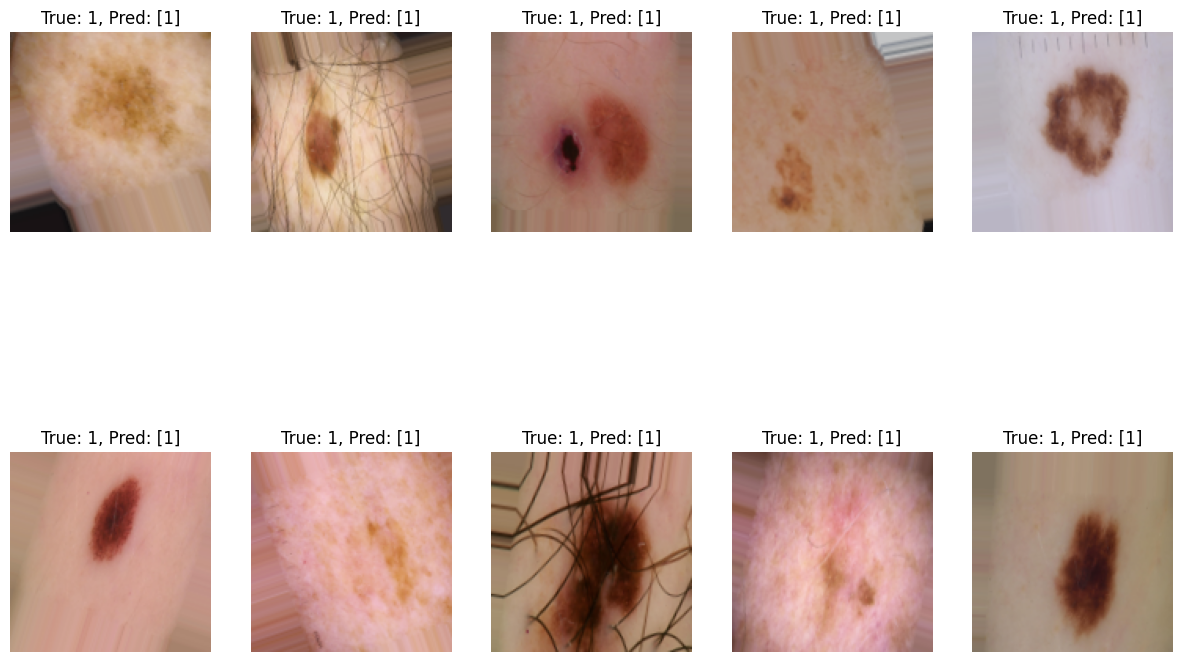

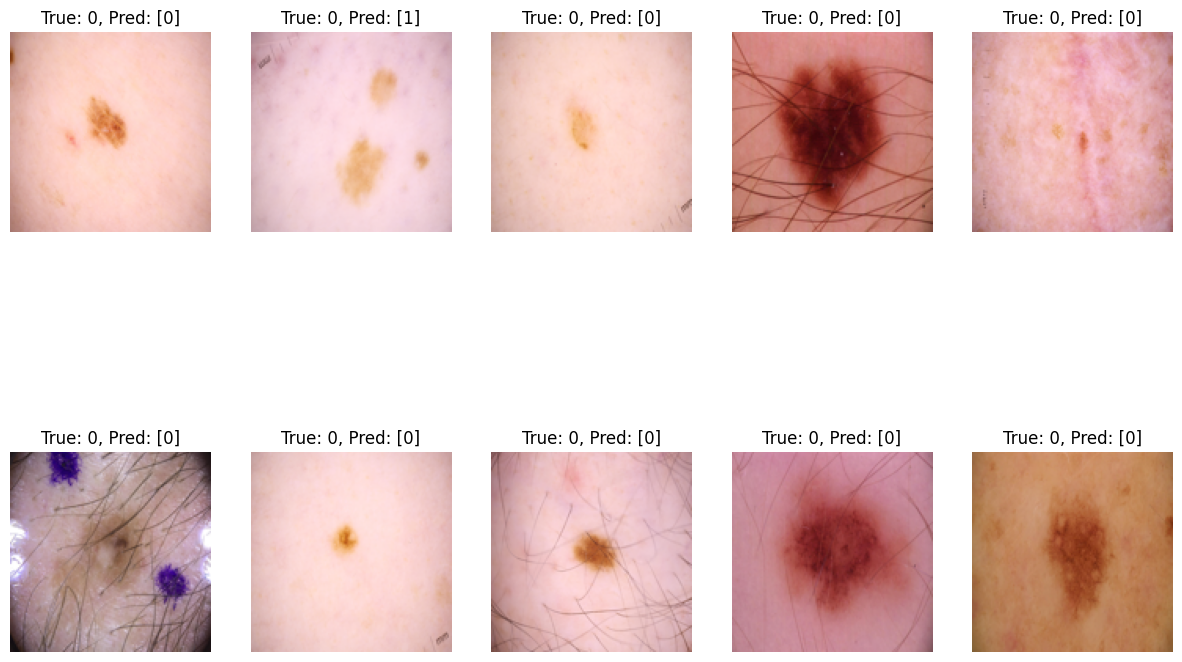

In [7]:
# Beispielbilder anzeigen
def plot_predictions(images, targets, predictions, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {targets[i]}, Pred: {predictions[i]}")
        plt.axis('off')
        
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(images[-(i+1)])
        plt.title(f"True: {targets[-(i+1)]}, Pred: {predictions[-(i+1)]}")
        plt.axis('off')
    
    plt.show()

# Beispielbilder von Positiv und Negativ anzeigen
melanoma_indices = np.where(val_targets_balanced == 1)[0]
non_melanoma_indices = np.where(val_targets_balanced == 0)[0]

# Sicherstellen, dass die Indizes nicht außerhalb des Bereichs liegen
melanoma_indices = melanoma_indices[melanoma_indices < len(val_images_balanced)]
non_melanoma_indices = non_melanoma_indices[non_melanoma_indices < len(val_images_balanced)]

plot_predictions(val_images_balanced[melanoma_indices], val_targets_balanced[melanoma_indices], val_predictions[melanoma_indices])
plot_predictions(val_images_balanced[non_melanoma_indices], val_targets_balanced[non_melanoma_indices], val_predictions[non_melanoma_indices])

# Model speichern

In [8]:
model.save("/kaggle/working/modelfunktioniert.h5")
datetime.datetime.now().strftime("Fertiggestellt um %X den %x")

import gc
gc.collect()

52986

# Visualisierung der Ergebnisse

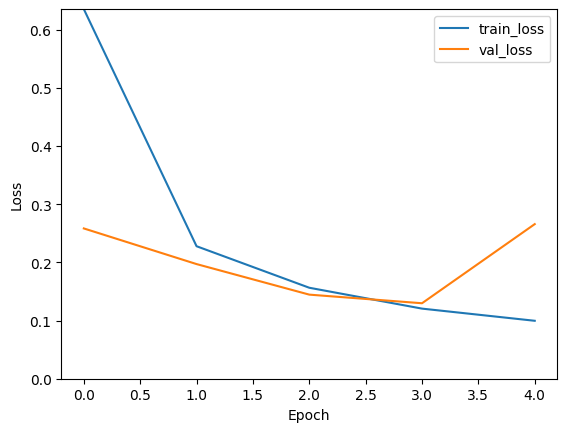

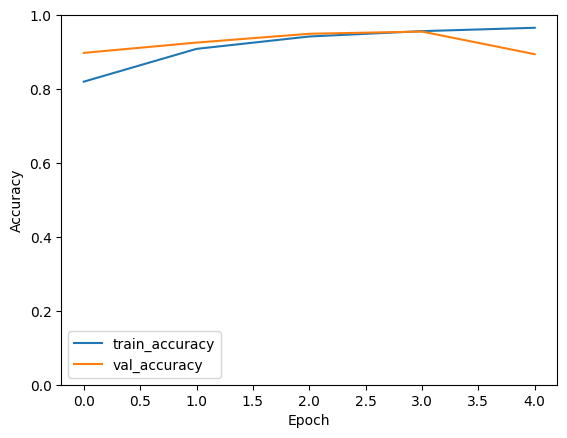

In [9]:
# Visualisierung der Trainings- und Validierungsverluste
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, max(history.history['loss'] + history.history['val_loss']))  # Setze die y-Achsenbegrenzung von 0 bis zum maximalen Verlustwert
plt.legend()
plt.show()

# Visualisierung der Trainings- und Validierungsgenauigkeit
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Setze die y-Achsenbegrenzung von 0 bis 1 für die Genauigkeit
plt.legend()
plt.show()

Die Konfusionsmatrix zeigt hohe Werte in TP und TN an, was bedeutet, dass das Modell richtig funktioniert

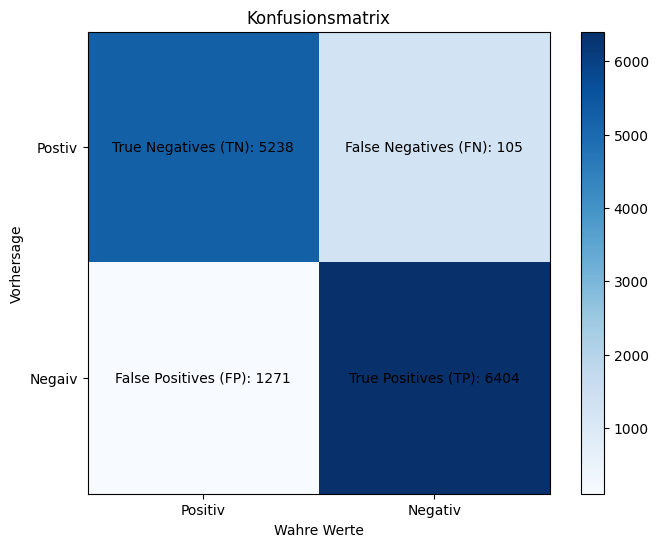

In [10]:

conf_matrix = confusion_matrix(val_targets_balanced, val_predictions)

# Berechnung von TP, TN, FP und FN
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Plot der Confusion Matrix mit Werten
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Konfusionsmatrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Positiv', 'Negativ'])
plt.yticks(tick_marks, ['Postiv', 'Negaiv'])
plt.xlabel('Wahre Werte')
plt.ylabel('Vorhersage')

# Anzeigen von TP, TN, FP und FN
plt.text(0, 0, f"True Negatives (TN): {TN}", horizontalalignment='center', verticalalignment='center', color='black')
plt.text(1, 1, f"True Positives (TP): {TP}", horizontalalignment='center', verticalalignment='center', color='black')
plt.text(0, 1, f"False Positives (FP): {FP}", horizontalalignment='center', verticalalignment='center', color='black')
plt.text(1, 0, f"False Negatives (FN): {FN}", horizontalalignment='center', verticalalignment='center', color='black')

plt.show()